### Simulating EIGENSTRAT in a variant interaction scenario

In [1]:
import numpy as np
from numpy import ma
import pandas as pd
import copy

# stats
from scipy.stats import chi2

# plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 250


In [290]:
M = 10000
p = np.random.uniform(0.1, 0.9, size=(M, 1))

In [291]:
f_st = 0.1

In [292]:
a, b = p * (1-f_st)/f_st, (1-p) * (1-f_st)/f_st

In [296]:
Y = np.random.beta(a, b, size=(M, 1000))

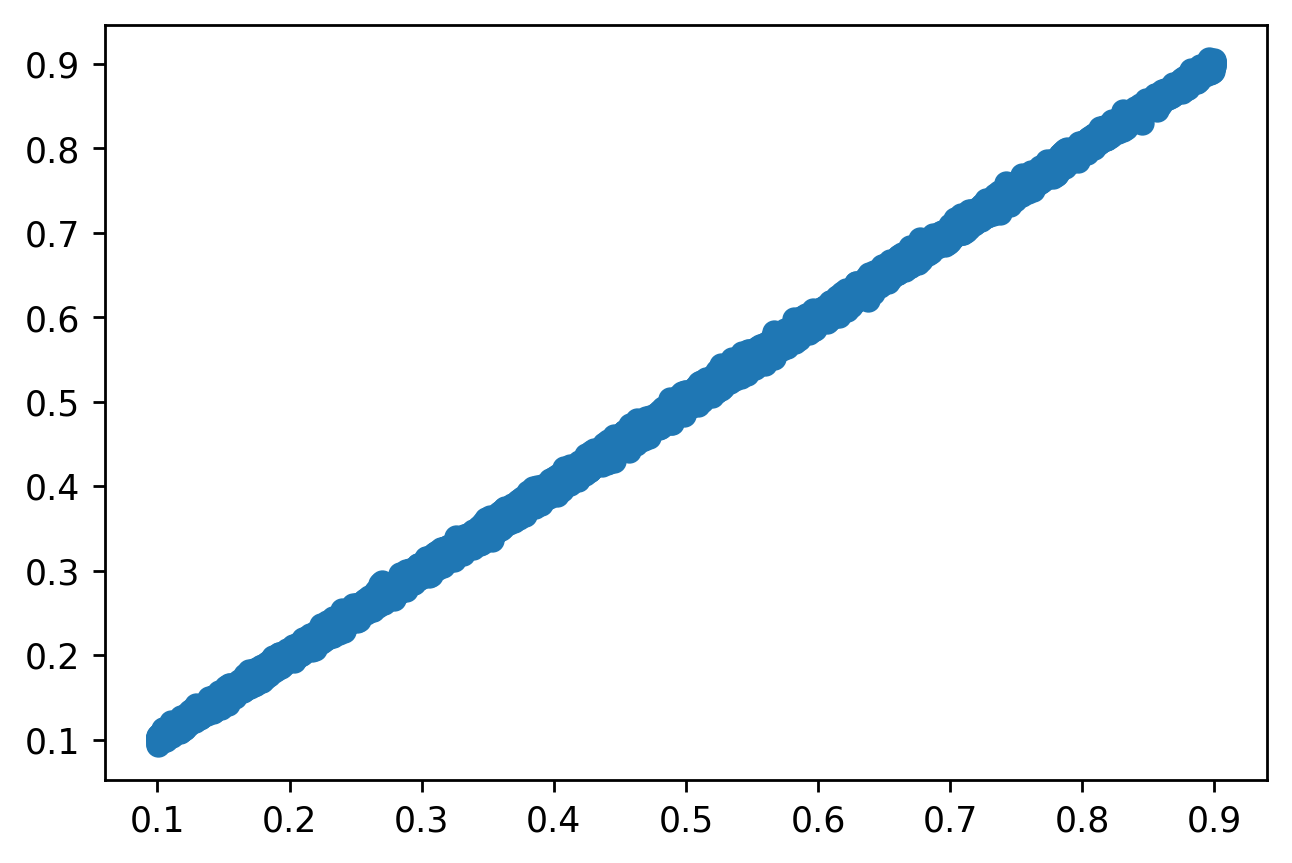

In [297]:
plt.scatter(p, Y.mean(1))

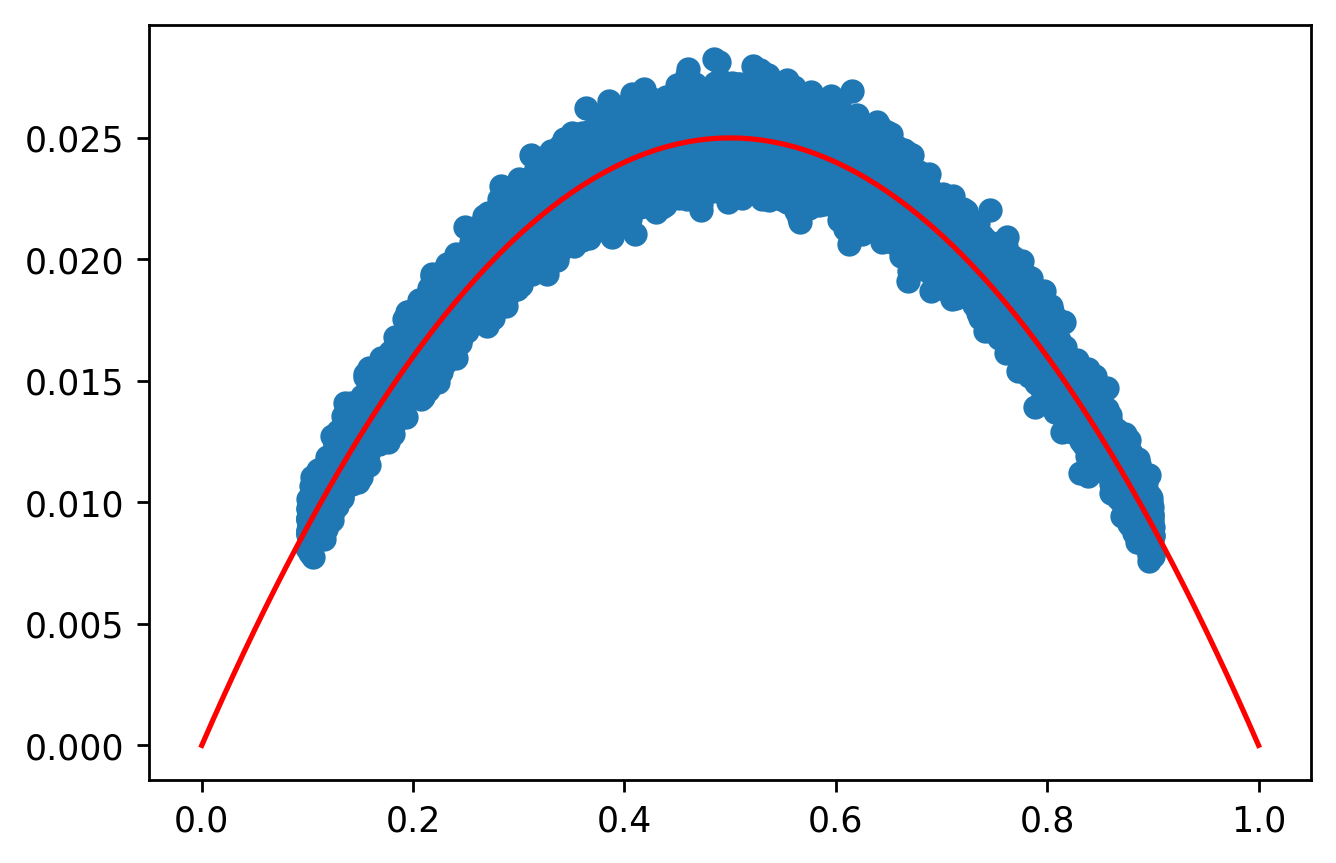

In [298]:
plt.scatter(p, Y.var(1))
x = np.arange(0, 1.01, 0.01)
plt.plot(x, f_st * x * (1 - x), color='red')

In [299]:
K = 1000
alpha1 = (p * (K - f_st) - (p**2) * (1 - f_st))/K/f_st/(1-p)

In [300]:
alpha0 = alpha1 * K * (1 - p) / p

In [301]:
alphas = np.hstack((np.repeat(alpha1, K, axis=1), alpha0))

In [328]:
X = np.vstack([np.random.dirichlet(a) for a in alphas]) * (K)

In [329]:
X = X[:, :-1]

In [330]:
X_ = X/X.max(1, keepdims=True)

In [331]:
X[X>1]=1

In [332]:
X[X>1].size/X.size

0.0

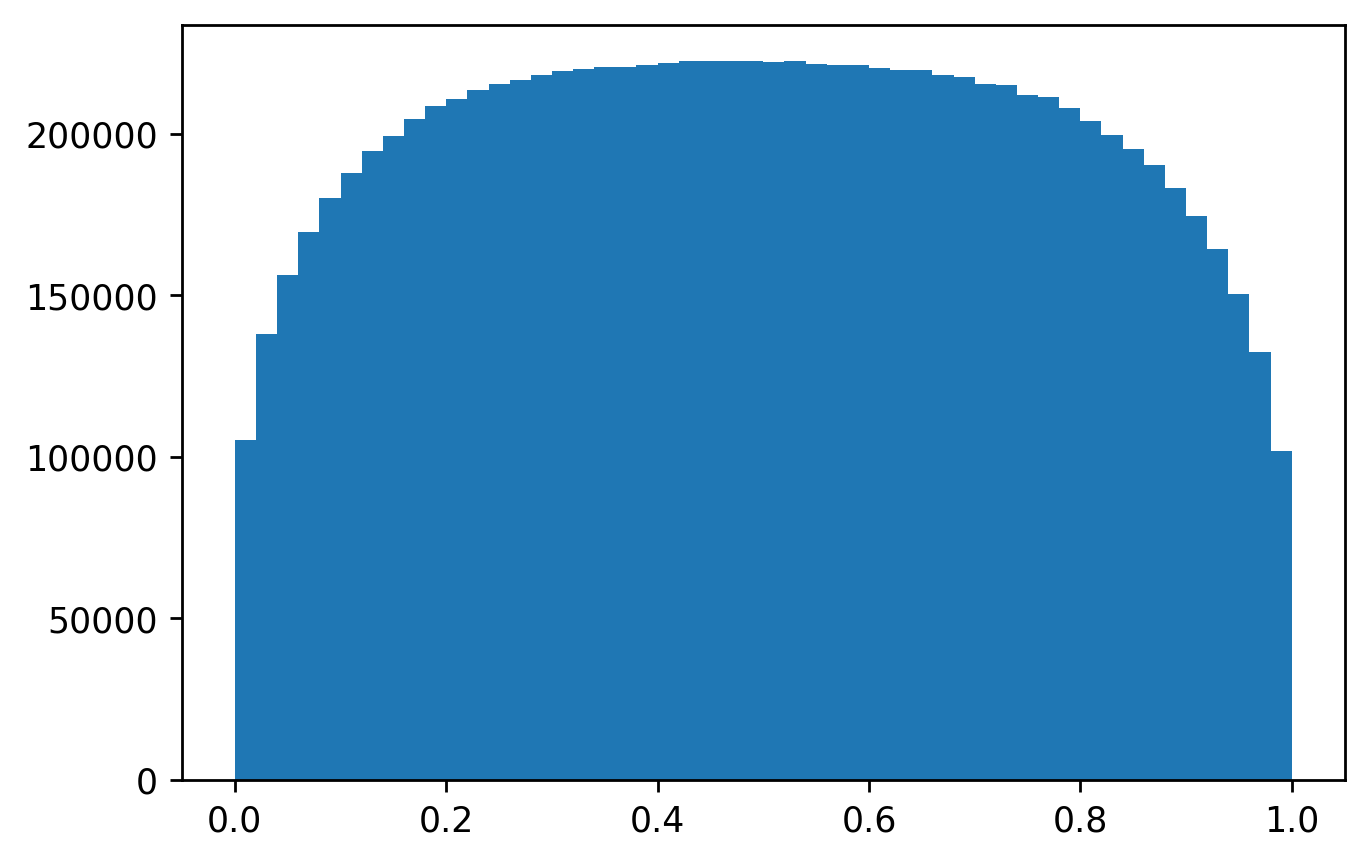

In [333]:
plt.hist(Y.flatten(), bins=50);

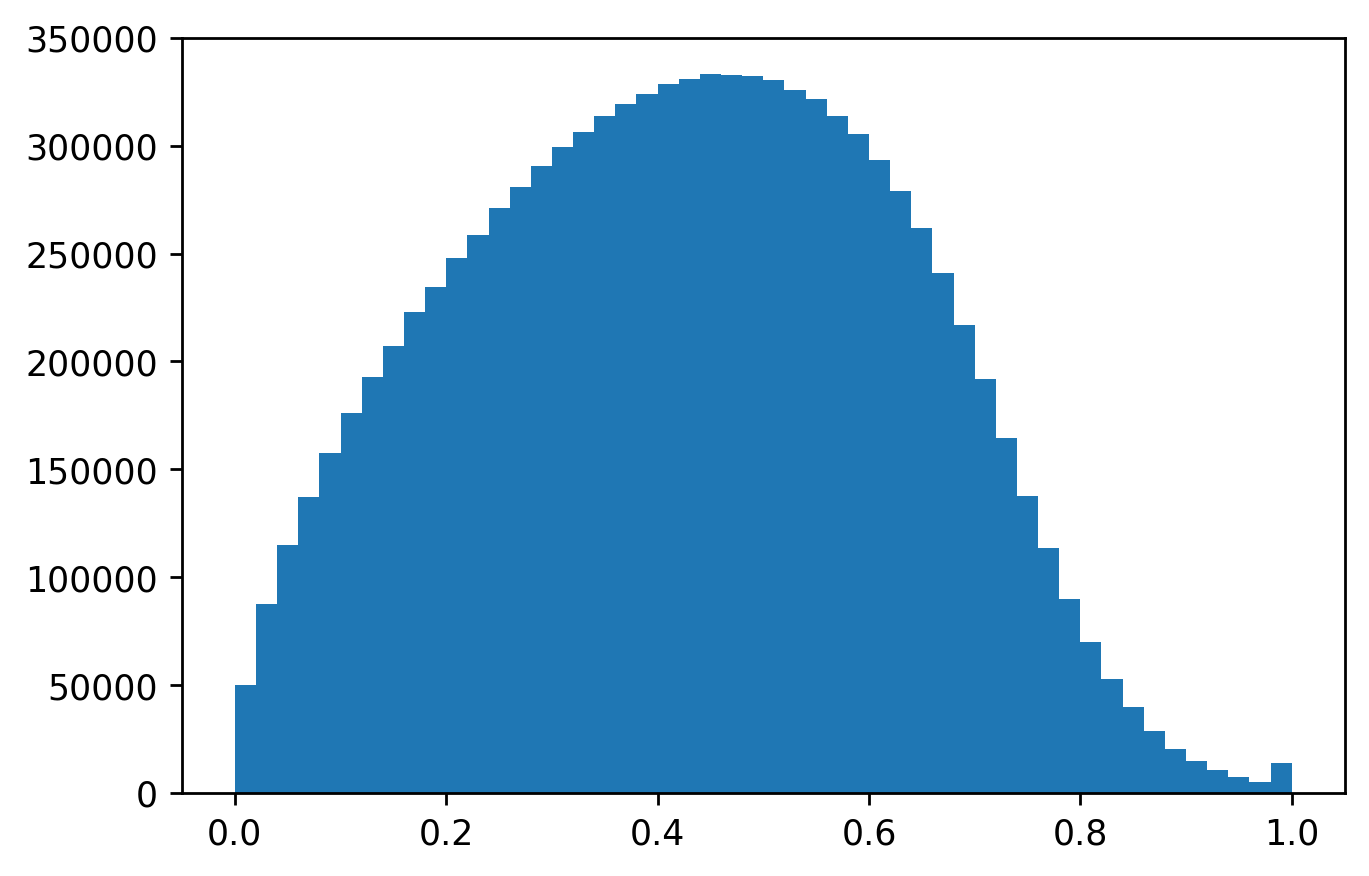

In [334]:
plt.hist(X_.flatten(), bins=50);

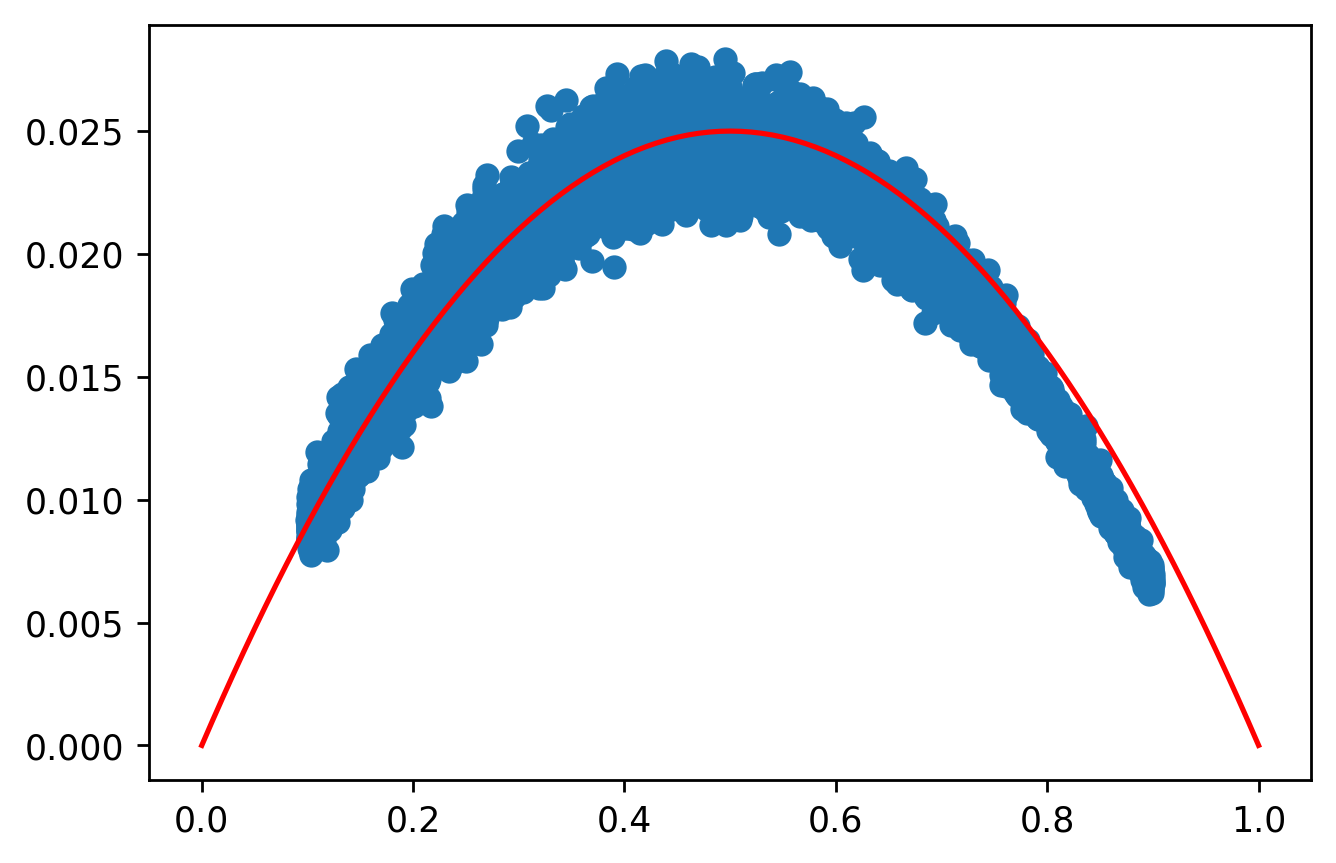

In [336]:
plt.scatter(p, X.var(1))
x = np.arange(0, 1.01, 0.01)
plt.plot(x, f_st * x * (1 - x), c='red')

In [181]:
X

array([[0.2613806 , 0.07178663, 0.28087909, ..., 0.48717159, 0.54624383,
        0.35809713],
       [0.26359757, 0.35086531, 0.1531495 , ..., 0.27990645, 0.38762264,
        0.19898881],
       [0.2063974 , 0.15999521, 0.10138506, ..., 0.08377614, 0.39759821,
        0.0555237 ],
       ...,
       [0.02829896, 0.32515589, 0.03326277, ..., 0.21838704, 0.00403747,
        0.21628186],
       [0.85735045, 0.98175716, 0.83721477, ..., 0.75009466, 0.73058148,
        0.81983858],
       [0.9791195 , 1.02894106, 0.91221996, ..., 0.91112727, 0.99295127,
        0.95863233]])

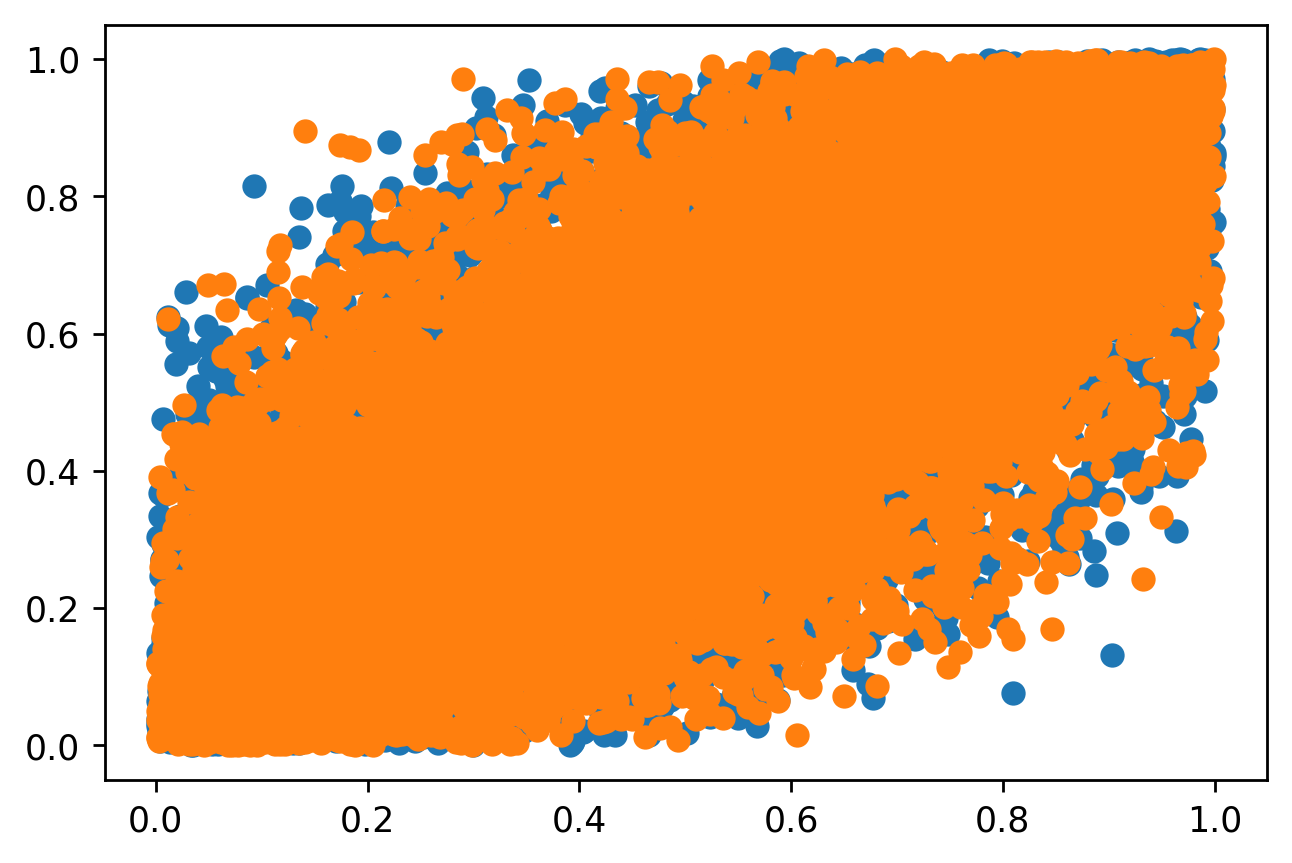

In [315]:
plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(Y[:, 0], Y[:, 10])

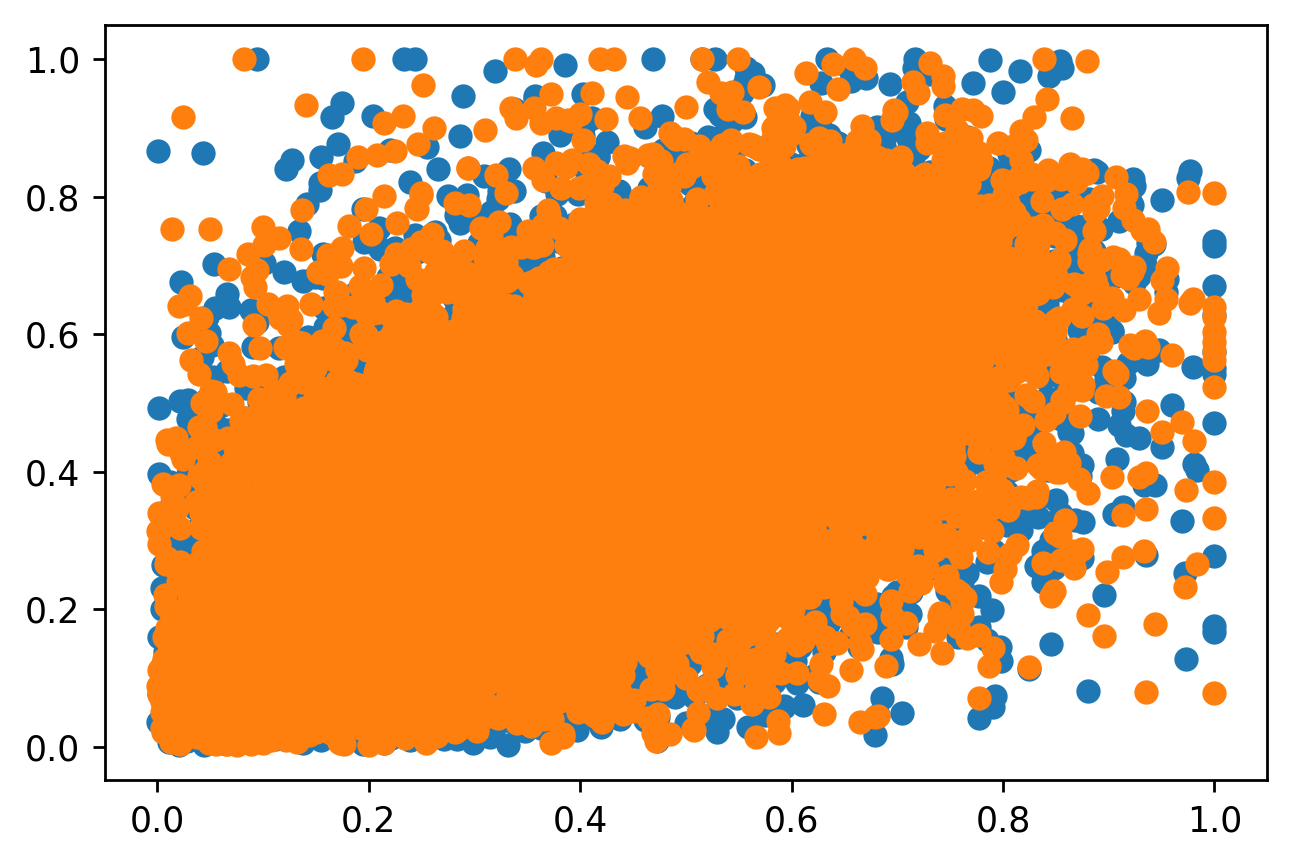

In [337]:
plt.scatter(X_[:, 0], X_[:, 1])
plt.scatter(X_[:, 0], X_[:, 10])

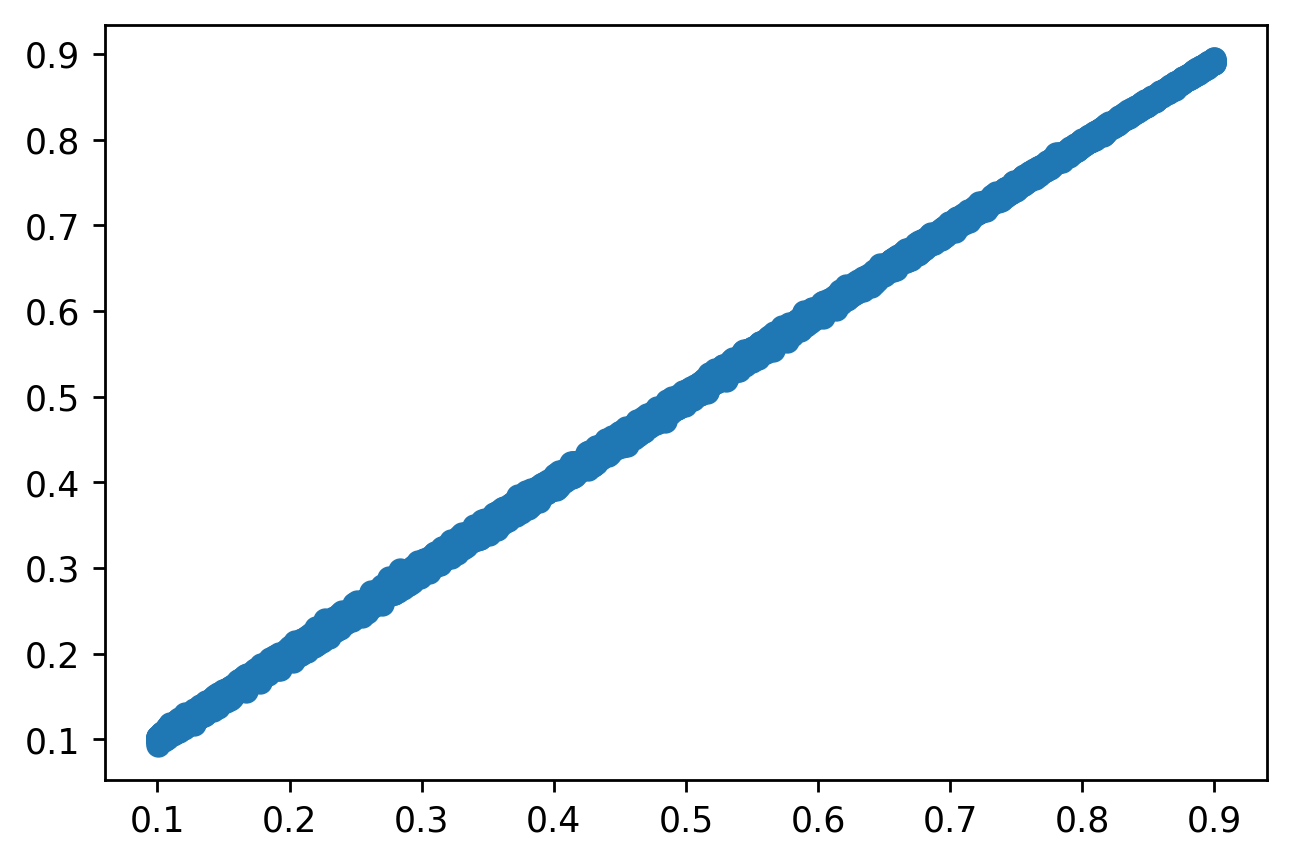

In [317]:
plt.scatter(p, X.mean(1))

In [183]:
np.corrcoef(Y[:, 0], Y[:, 1])

array([[1.        , 0.81647046],
       [0.81647046, 1.        ]])

In [184]:
np.cov(X[:, 0], X[:, 1])

array([[0.09459322, 0.07603479],
       [0.07603479, 0.09278608]])

In [ ]:
class BaldingNicholsSimulation:
    def __init__(
        self,
        n_pop=10,
        n_snps=1000,
        f_st=0.01,
    ):
        self.K, self.M, self.f_st = n_pop, n_snps, f_st
        self.pj = np.random.uniform(0.1, 0.9, size=(self.M, 1))
        a, b = self.pj * (1-f_st)/f_st, (1-self.pj) * (1-f_st)/f_st
        self.pjk = np.random.beta(a, b, size=(self.M, self.K))
        

In [51]:
def sample_snps(n_samples, p, R=1):
    """Efficiently draw many samples of SNPs with different frequencies
    
    This implementation uses the universality of the Uniform to sample
    from a multinomial distribution.
    
    Parameters:
    -----------
        n_samples: (int) The number of samples of each SNP to be drawn.
        p: (NumPy array) Array of allele frequencies.
        R: (int or float) Relative risk as seen in Price et al. 2006.
        
    Returns:
    --------
        p_adj: (NumPy array) Adjusted allele frequencies, which are identical
            to input `p` unless `R` is not 1.
        geno: (NumPy matrix) Genotypes of dimensions (n_sns, n_samples).
    
    """
    n_snps = len(p)
    
    # compute PMF and CDF
    geno_pmf = np.vstack(((1-p)**2, 2*R*p*(1-p), (R*p)**2)).T
    geno_pmf = geno_pmf / geno_pmf.sum(1, keepdims=True)
    p_adj = np.sqrt(geno_pmf[:, 2])
    geno_cdf = np.cumsum(geno_pmf, axis=1)
    
    # samples using the universality of the Uniform
    geno = np.ones((n_snps, n_samples)) * 2
    unif = np.random.uniform(size = (n_snps, n_samples))
    geno[unif < geno_cdf[:, [1]]] = 1
    geno[unif < geno_cdf[:, [0]]] = 0
    
    return p_adj, geno
    
    
class EigenstratSimpleSimulation:
    def __init__(
        self, 
        pop1_size=500,
        pop2_size=500, 
        n_cases=500, 
        cases_in_pop1=300, 
        f_st = 0.01,
        pop1_diff_af = 0.8,
        pop2_diff_af = 0.2,
        rel_risk = 1.5,
        n_snps_per_class = 50_000
    ):
        self.pop1_size, self.pop2_size = pop1_size, pop2_size
        self.pop_size = pop1_size + pop2_size
        self.n_cases, self.n_controls = n_cases, self.pop_size - n_cases
        self.cases_in_pop1 = cases_in_pop1
        self.f_st, self.rel_risk = f_st, rel_risk
        self.pop1_diff_af, self.pop2_diff_af = pop1_diff_af, pop2_diff_af
        self.n_snps_per_class = n_snps_per_class
        self.n_snps = 3 * n_snps_per_class
        
        self.pop = np.array([0]*pop1_size + [1]*pop2_size)
        self.cases = np.array([1]* cases_in_pop1 + 
                              [0]* (pop1_size - cases_in_pop1) + 
                              [1]* (n_cases - cases_in_pop1) +
                              [0]* (pop2_size - (n_cases - cases_in_pop1)))
        
        # sample the ancestral frequencies of non-causal SNPs
        self.p_nc = np.random.uniform(0.1, 0.9, size=n_snps_per_class)
        # sample the population AFs
        self.p_nc_1 = np.random.beta(a=self.p_nc * (1-f_st)/f_st, b=(1-self.p_nc)*(1-f_st)/f_st)
        self.p_nc_2 = np.random.beta(a=self.p_nc * (1-f_st)/f_st, b=(1-self.p_nc)*(1-f_st)/f_st)
        # sample the genotypes
        _, self.geno_nc_1 = sample_snps(pop1_size, self.p_nc_1)
        _, self.geno_nc_2 = sample_snps(pop2_size, self.p_nc_2)
        self.geno_nc = np.hstack((self.geno_nc_1, self.geno_nc_2))
        
        # sample the genotypes for non-causal differentiating SNPs
        _, self.geno_diff_1 = sample_snps(pop1_size, np.array([pop1_diff_af]*n_snps_per_class))
        _, self.geno_diff_2 = sample_snps(pop2_size, np.array([pop2_diff_af]*n_snps_per_class))
        self.geno_diff = np.hstack((self.geno_diff_1, self.geno_diff_2))
        
        # sample the ancestral frequencies of causal SNPs
        self.p_c = np.random.uniform(0.1, 0.9, size=n_snps_per_class)
        # sample the population AFs
        self.p_c_1 = np.random.beta(a=self.p_c * (1-f_st)/f_st, b=(1-self.p_c)*(1-f_st)/f_st)
        self.p_c_2 = np.random.beta(a=self.p_c * (1-f_st)/f_st, b=(1-self.p_c)*(1-f_st)/f_st)
        # sample the genotypes
        self.p_c_1_adj, self.geno_c_cases_1 = sample_snps(cases_in_pop1, self.p_c_1, R=rel_risk)
        _, self.geno_c_controls_1 = sample_snps(pop1_size - cases_in_pop1, self.p_c_1, R=1)
        self.p_c_2_adj, self.geno_c_cases_2 = sample_snps(n_cases - cases_in_pop1, self.p_c_2, R=rel_risk)
        _, self.geno_c_controls_2 = sample_snps(pop2_size - (n_cases - cases_in_pop1), self.p_c_2, R=1)
        self.geno_c = np.hstack((self.geno_c_cases_1, 
                                 self.geno_c_controls_1, 
                                 self.geno_c_cases_2, 
                                 self.geno_c_controls_2))
        
        # combine all genotypes into one matrix
        self.geno = np.vstack((self.geno_c, self.geno_diff, self.geno_nc))

In [43]:
def eigenstrat_adjust(geno, pheno, pcs):
    """Adjust genotype and phenotype values using PCA eigenvectors
    
    Parameters:
    -----------
        geno: (NumPy array) genotypes of dimensions (num_snps, num_samples).
        pheno: (NumPy array) phenotypes of dimensions (num_samples,).
        pcs: (NumPy array) PCA eigenvectors of dimensions (num_samples, num_pcs).
    
    Returns:
    --------
        adj_geno, adj_pheno: PCA-adjusted genotypes and phenotypes with same 
            dimensions as corresponding inputs.
    """
    
    C_geno = np.dot(geno, pcs) / np.power(pcs, 2).sum(0, keepdims=True)
    adj_geno = geno - np.dot(C_geno, pcs.T)
    
    pheno = pheno[np.newaxis, :]
    C_pheno = np.dot(pheno, pcs) / np.power(pcs, 2).sum(0, keepdims=True)
    adj_pheno = pheno - np.dot(C_pheno, pcs.T)
    
    return adj_geno, adj_pheno.flatten()

def gp_correlation(geno, pheno):
    """Compute correlation between genotypes and a single phenotype
    
    Parameters:
    -----------
        geno: (NumPy array) Genotypes of dimensions (num_snps, num_samples).
        pheno: (NumPy array) Phenotypes of dimensions (num_samples,).
    
    Returns:
    --------
        corr: (NumPy arrays) GP correlations of dimensions (n_snsp,).
        
    """
    geno_norm = (geno - geno.mean(1, keepdims=True))/geno.std(axis=1, keepdims=True)
    pheno_norm = (pheno - pheno.mean())/pheno.std()
    
    corr = (geno_norm * pheno_norm).mean(1)
    return corr
    
def armitage_trend_test(geno, pheno, pcs=None):
    '''
    Compute Cochran-Armitage trend test statistics using correlations
    
    Inputs:
        - geno: (masked NumPy array) genotypes data ({0,1,2,--}) of dimensions
        (num_snps, num_samples)
        - pheno: (NumPy array) phenotyoes data ({0,1}) of dimensions
        (num_samples,)
        - pcs: (NumPy array) PCA eigenvectors of dimensions (num_samples, num_pcs)
    Outputs:
        - stats, pvalues: (NumPy array) Armitage trend statistics and 
        p-values of dimensions (n_snps,) each
    '''
    N = len(pheno)
    if not pcs is None:
        geno, pheno = eigenstrat_adjust(geno, pheno, pcs)
        N = N - pcs.shape[1]
    corrs = gp_correlation(geno, pheno)
    stats = (N - 1) * np.power(corrs, 2)
    pvalues = 1-chi2.cdf(stats, df = 1)
    
    return stats, pvalues


In [52]:
sim = EigenstratSimpleSimulation(n_snps_per_class=10_000)

In [53]:
stats, pvalues = armitage_trend_test(sim.geno, sim.cases)

In [54]:
pcs = sim.pop

In [55]:
pcs = pcs - pcs.mean()
pcs = pcs / np.linalg.norm(pcs)

In [56]:
stats_adj, pvalues_adj = armitage_trend_test(sim.geno, sim.cases, pcs = pcs[:, np.newaxis])

In [61]:
(pvalues[10000:20000] < 1e-4).sum()

8518

In [16]:
pvalues_adj.min()

1.6675243519337357e-08

In [27]:
len(pvalues_adj)

150000

In [34]:
(pvalues_adj[:50000] <= 1e-4).sum()

2339

/tmp/ipykernel_12618/2905456357.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(pvalues[:50_000]), -np.log10(pvalues_adj[:50_000]), s=1)
/tmp/ipykernel_12618/2905456357.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(pvalues[-50_000:]), -np.log10(pvalues_adj[-50_000:]), s=1)


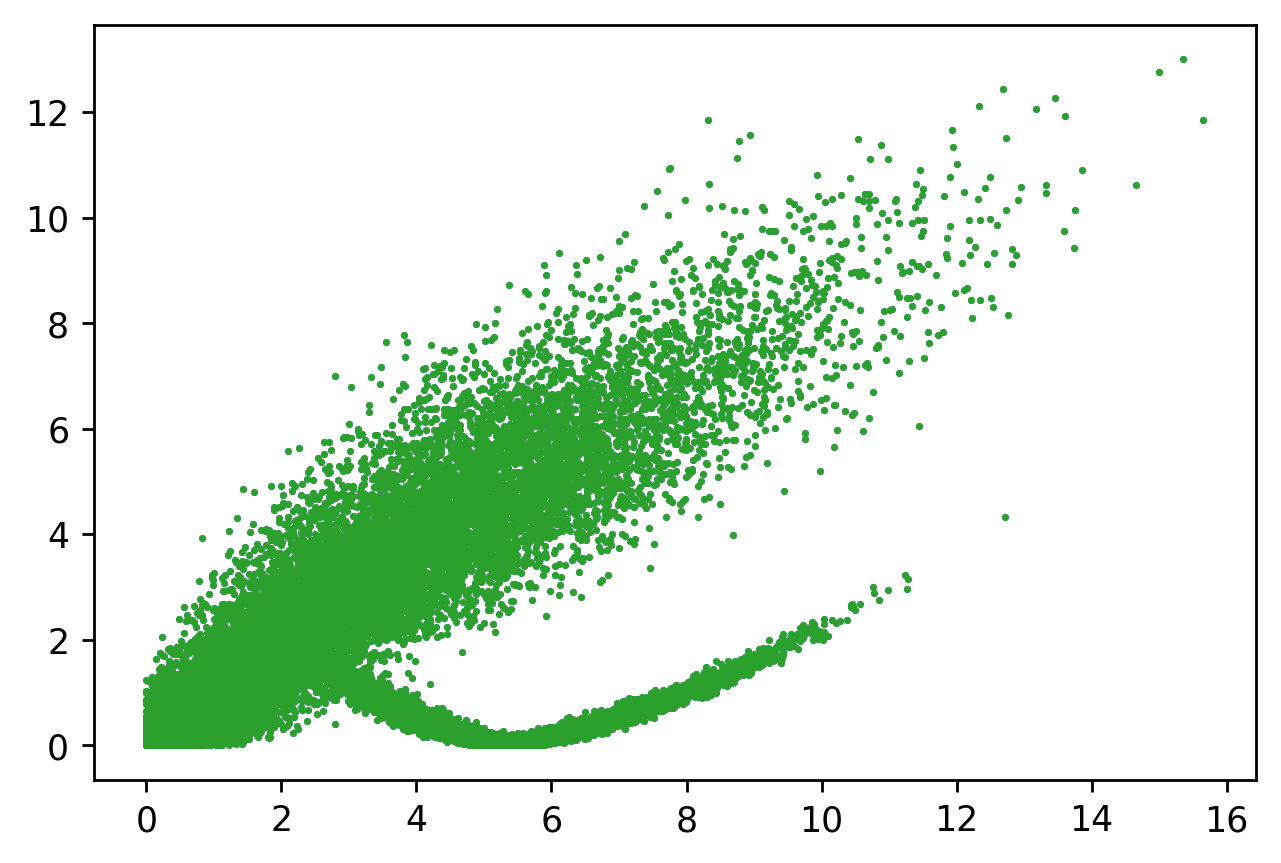

In [58]:
plt.scatter(-np.log10(pvalues[:50_000]), -np.log10(pvalues_adj[:50_000]), s=1)
plt.scatter(-np.log10(pvalues[50_000:100_000]), -np.log10(pvalues_adj[50_000:100_000]), s=1)
plt.scatter(-np.log10(pvalues[-50_000:]), -np.log10(pvalues_adj[-50_000:]), s=1)